In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

/Users/mahdie/opt/anaconda3/envs/physioai/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# OAI dataset
df = pd.read_csv("preprocessed_OAI.csv")
df.shape

# GLAD dataset
dfg = pd.read_csv("preprocessed_Glad.csv")

In [3]:
df

,V00AGE,P02SEX,P01BMI,V00CESD6,V00CEMPLOY_employment,PA_baseline_category,PA_followup_category,V00KOOSQOL,V01KOOSQOL,knee_pain_baseline,knee_pain_follow
0,78.0,1.0,27.6,1.0,3.0,1,1,50.00,68.75,80.0,50.0
1,76.0,2.0,27.4,1.0,3.0,1,3,100.00,62.50,0.0,40.0
2,69.0,1.0,29.8,1.0,3.0,1,4,81.25,100.00,10.0,0.0
3,68.0,2.0,30.1,2.0,3.0,1,1,75.00,81.25,30.0,30.0
4,76.0,1.0,32.4,1.0,2.0,1,1,75.00,68.75,30.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
4126,56.0,1.0,24.1,1.0,1.0,10,9,100.00,100.00,0.0,0.0
4127,59.0,2.0,30.5,1.0,1.0,10,6,43.75,68.75,70.0,70.0
4128,70.0,1.0,33.9,1.0,3.0,10,5,100.00,100.00,0.0,0.0
4129,52.0,1.0,30.7,1.0,1.0,10,8,31.25,37.50,50.0,70.0


In [4]:
dfg

,age,gender,fysb_BMI,ptb_14618_depression,ptb_3777_employment,ptb_4145,pt12_4145,ptb_koos_qol_score,pt12_koos_qol_score,ptb_3764,pt12_3764
0,50,2,22.68,1.0,1.0,10.0,10.0,31.25,56.25,65.0,17.0
1,45,1,29.07,1.0,1.0,7.0,10.0,25.00,43.75,96.0,52.0
2,46,2,26.10,1.0,1.0,3.0,9.0,68.75,62.50,39.0,25.0
3,53,2,28.03,1.0,1.0,4.0,4.0,62.50,87.50,15.0,2.0
4,68,2,27.82,1.0,1.0,8.0,10.0,87.50,93.75,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7598,55,2,35.63,1.0,1.0,8.0,10.0,50.00,56.25,57.0,9.0
7599,61,2,29.34,1.0,1.0,3.0,6.0,25.00,68.75,55.0,8.0
7600,62,1,25.88,1.0,1.0,3.0,3.0,50.00,25.00,26.0,77.0
7601,47,2,26.51,1.0,1.0,4.0,2.0,43.75,18.75,47.0,92.0


#### Outcomes

##### Physical activity in OAI:

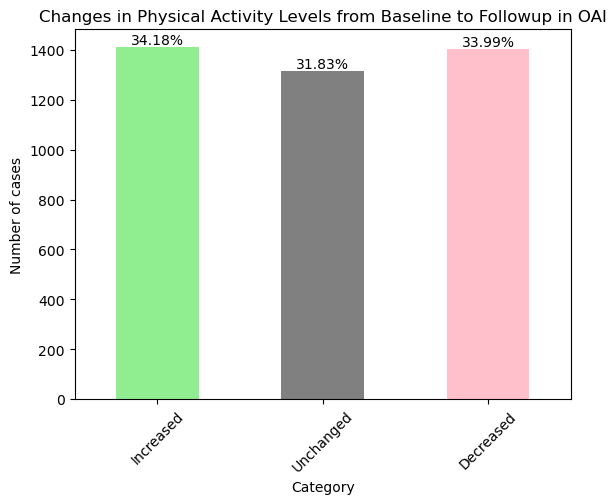

(4131, 15)


In [23]:
# Ensure the columns are of type 'category'
df['PA_followup_category'] = df['PA_followup_category'].astype('category')
df['PA_baseline_category'] = df['PA_baseline_category'].astype('category')

# Convert categories to codes if they are ordinal
df['PA_followup_category_code'] = df['PA_followup_category'].cat.codes
df['PA_baseline_category_code'] = df['PA_baseline_category'].cat.codes

# Calculate the difference
df['PA_change'] = df['PA_followup_category_code'] - df['PA_baseline_category_code']

# Define the function to categorize PA_changes
def categorize_change(PA_change):
    if PA_change > 0:
        return 'Increased'
    elif PA_change < 0:
        return 'Decreased'
    else:
        return 'Unchanged'

# Apply the function to categorize PA_changes
df['PA_change_category'] = df['PA_change'].apply(categorize_change)

# Calculate counts for each category of PA_change
change_counts = df['PA_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'pink'])
plt.title('Changes in Physical Activity Levels from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()
print(df.shape)

##### Physical activity in GLA:D

In [6]:
df

,V00AGE,P02SEX,P01BMI,V00CESD6,V00CEMPLOY_employment,PA_baseline_category,PA_followup_category,V00KOOSQOL,V01KOOSQOL,knee_pain_baseline,knee_pain_follow
0,78.0,1.0,27.6,1.0,3.0,1,1,50.00,68.75,80.0,50.0
1,76.0,2.0,27.4,1.0,3.0,1,3,100.00,62.50,0.0,40.0
2,69.0,1.0,29.8,1.0,3.0,1,4,81.25,100.00,10.0,0.0
3,68.0,2.0,30.1,2.0,3.0,1,1,75.00,81.25,30.0,30.0
4,76.0,1.0,32.4,1.0,2.0,1,1,75.00,68.75,30.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
4126,56.0,1.0,24.1,1.0,1.0,10,9,100.00,100.00,0.0,0.0
4127,59.0,2.0,30.5,1.0,1.0,10,6,43.75,68.75,70.0,70.0
4128,70.0,1.0,33.9,1.0,3.0,10,5,100.00,100.00,0.0,0.0
4129,52.0,1.0,30.7,1.0,1.0,10,8,31.25,37.50,50.0,70.0


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_21125/3254585130.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, value, f'{percentages[i]}%', ha='center', va='bottom')


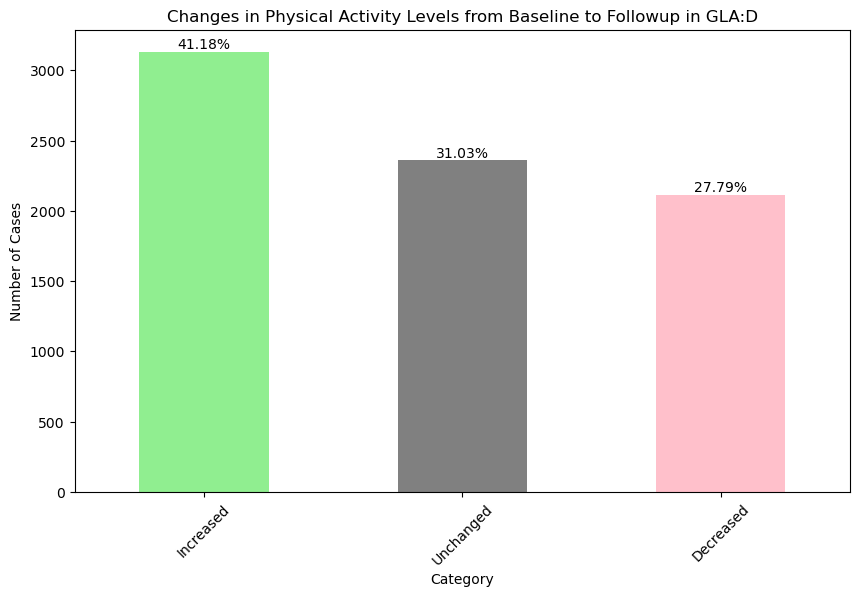

(7603, 13)


In [25]:
# Calculate the difference
dfg['PA_change'] = dfg['pt12_4145'] - dfg['ptb_4145']

# Categorize the PA_changes
dfg['PA_change_category'] = pd.cut(dfg['PA_change'], bins=[float('-inf'), -0.01, 0.01, float('inf')],
                               labels=['Decreased', 'Unchanged', 'Increased'])

# Ensure the order: Increased, Unchanged, Decreased
order = ['Increased', 'Unchanged', 'Decreased']

# Count the number of cases in each category, reindex to ensure order
PA_change_counts = dfg['PA_change_category'].value_counts().reindex(order)

# Calculate percentages
total = PA_change_counts.sum()
percentages = (PA_change_counts / total * 100).round(2)

# Specify colors for each category
colors = ['lightgreen', 'grey', 'pink']

# Visualize the results with a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
PA_change_counts.plot(kind='bar', color=colors, ax=ax)
plt.title('Changes in Physical Activity Levels from Baseline to Followup in GLA:D')
ax.set_xlabel('Category')
ax.set_ylabel('Number of Cases')
plt.xticks(rotation=45)

# Annotate each bar with the percentage of cases
for i, value in enumerate(PA_change_counts.values):
    ax.text(i, value, f'{percentages[i]}%', ha='center', va='bottom')

plt.show()
print(dfg.shape)

##### Quality of life in OAI

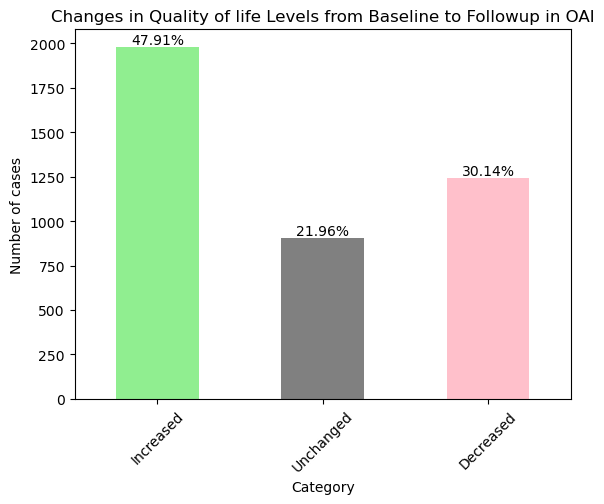

In [26]:
# Calculate the difference
df['QOL_change'] = df['V01KOOSQOL'] - df['V00KOOSQOL']


# Define the function to categorize QOL_changes
def QOL_categorize_change(QOL_change):
    if QOL_change > 0:
        return 'Increased'
    elif QOL_change < 0:
        return 'Decreased'
    
    else:
        return 'Unchanged'

# Apply the function to categorize QOL_changes
df['QOL_change_category'] = df['QOL_change'].apply(QOL_categorize_change)

# Calculate counts for each category of QOL_change
change_counts = df['QOL_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'pink'])
plt.title('Changes in Quality of life Levels from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Quality of life in OAI: changes of at least 10 points

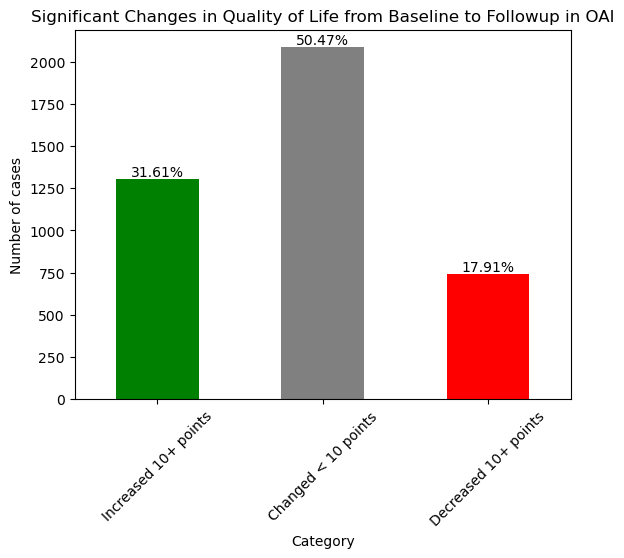

In [27]:
# Calculate the difference
df['QOL_change'] = df['V01KOOSQOL'] - df['V00KOOSQOL']

# Define the function to categorize changes of at least 10 points
def QOL_categorize_significant_change(QOL_change):
    if QOL_change >= 10:
        return 'Increased 10+ points'
    elif QOL_change <= -10:
        return 'Decreased 10+ points'
    else:
        return 'Changed < 10 points'
    
# Apply the function to categorize significant QOL_changes
df['QOL_significant_change_category'] = df['QOL_change'].apply(QOL_categorize_significant_change)

# Calculate counts for each category of significant QOL_change
change_counts = df['QOL_significant_change_category'].value_counts().reindex(['Increased 10+ points', 'Changed < 10 points', 'Decreased 10+ points'])

# Plot
ax = change_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Significant Changes in Quality of Life from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Quality of life in GLAD

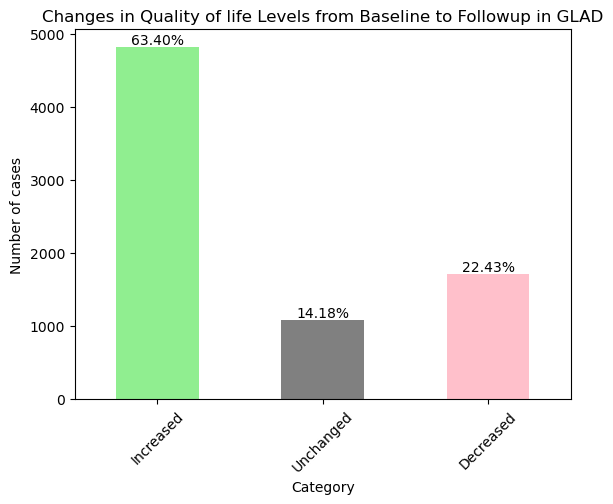

In [28]:
# Calculate the difference 
dfg['QOL_change'] = dfg['pt12_koos_qol_score'] - dfg['ptb_koos_qol_score']


# Define the function to categorize changes
def QOL_categorize_change(QOL_change):
    if QOL_change > 0:
        return 'Increased'
    elif QOL_change < 0:
        return 'Decreased'
    
    else:
        return 'Unchanged'

# Apply the function to categorize QOL_changes
dfg['QOL_change_category'] = dfg['QOL_change'].apply(QOL_categorize_change)

# Calculate counts for each category of QOL_change
QOL_change_counts = dfg['QOL_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = QOL_change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'pink'])
plt.title('Changes in Quality of life Levels from Baseline to Followup in GLAD')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = QOL_change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Quality of life in GLAD: changes of at least 10 point

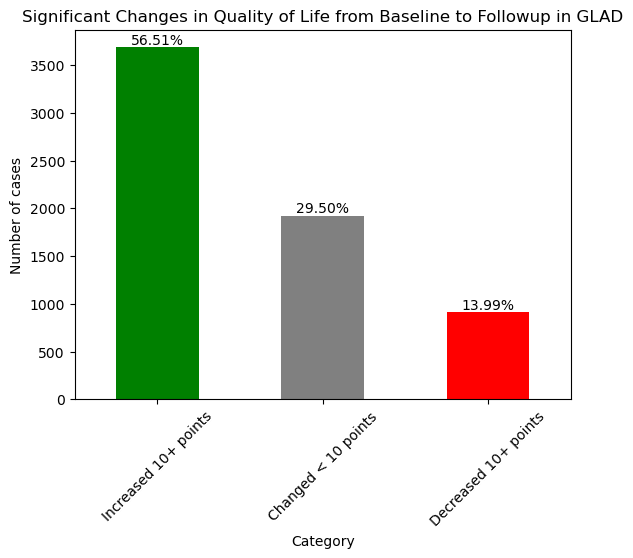

In [29]:
# Calculate the difference
dfg['QOL_change'] = dfg['pt12_koos_qol_score'] - dfg['ptb_koos_qol_score']

# Define the function to categorize changes of at least 10 points
def QOL_categorize_significant_change(QOL_change):
    if QOL_change >= 10:
        return 'Increased 10+ points'
    elif QOL_change <= -10:
        return 'Decreased 10+ points'
    elif QOL_change == 0:
        return 'Unchanged'
    else:
        return 'Changed < 10 points'

# Apply the function to categorize significant QOL_changes
dfg['QOL_significant_change_category'] = dfg['QOL_change'].apply(QOL_categorize_significant_change)

# Calculate counts for each category of significant QOL_change
QOL_significant_change_counts = dfg['QOL_significant_change_category'].value_counts().reindex(['Increased 10+ points', 'Changed < 10 points', 'Decreased 10+ points'])

# Plot
ax = QOL_significant_change_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Significant Changes in Quality of Life from Baseline to Followup in GLAD')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = QOL_significant_change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Pain in OAI

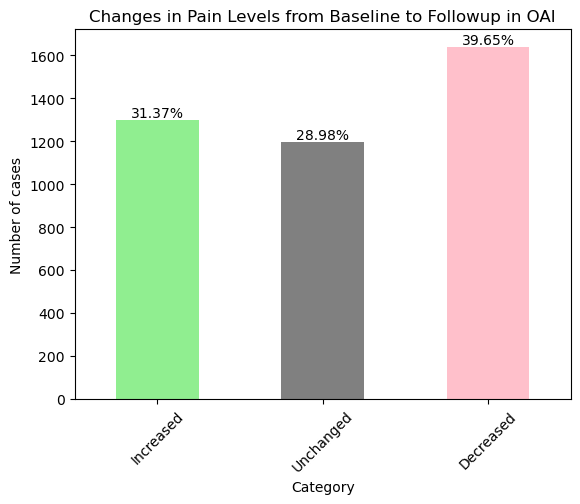

In [30]:
# Calculate the difference
df['pain_change'] = df['knee_pain_follow'] - df['knee_pain_baseline']

# Define the function to categorize changes
def pain_categorize_change(pain_change):
    if pain_change > 0:
        return 'Increased'
    elif pain_change < 0:
        return 'Decreased'
    
    else:
        return 'Unchanged'

# Apply the function to categorize pain_changes
df['pain_change_category'] = df['pain_change'].apply(pain_categorize_change)

# Calculate counts for each category of pain_change
change_counts = df['pain_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'pink'])
plt.title('Changes in Pain Levels from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Pain in OAI: changes of at least 10 points

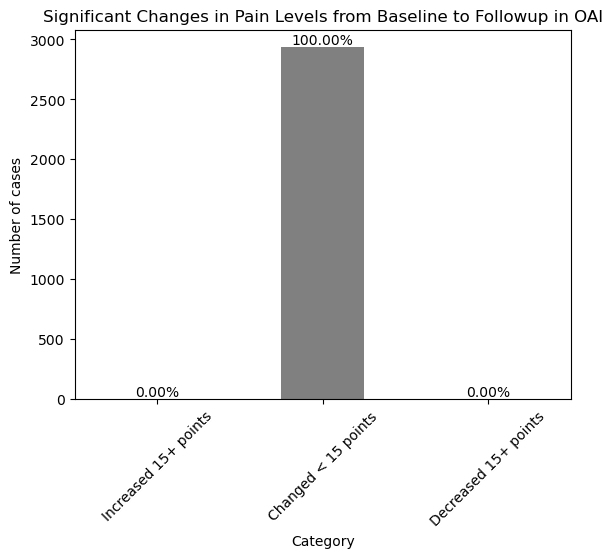

In [31]:
# Calculate the difference
df['pain_change'] = df['knee_pain_follow'] - df['knee_pain_baseline']

# Define the function to categorize changes of at least 15 points
def pain_categorize_significant_change(pain_change):
    if pain_change <= -15:
        return 'Decreased 15+ points'
    elif pain_change >= 15:
        return 'Increased 15+ points'
    elif pain_change == 0:
        return 'Unchanged'
    else:
        return 'Changed < 15 points'  # This now clearly means the pain changed but less than 15 points either way
    
# Apply the function to categorize significant pain changes
df['pain_significant_change_category'] = df['pain_change'].apply(pain_categorize_significant_change)

# Calculate counts for each category of significant pain change
change_counts = df['pain_significant_change_category'].value_counts().reindex(['Increased 15+ points', 'Changed < 15 points', 'Decreased 15+ points'])

# Plot
ax = change_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Significant Changes in Pain Levels from Baseline to Followup in OAI')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Pain in GLAD

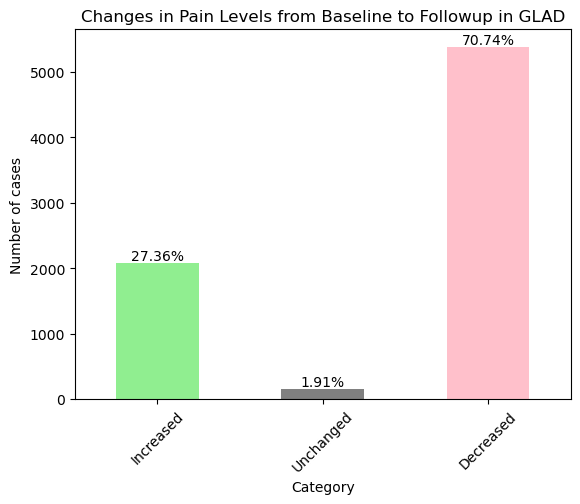

In [32]:
# Calculate the difference
dfg['pain_change'] = dfg['pt12_3764'] - dfg['ptb_3764']


# Define the function to categorize changes
def pain_categorize_change(pain_change):
    if pain_change > 0:
        return 'Increased'
    elif pain_change < 0:
        return 'Decreased'
    
    else:
        return 'Unchanged'

# Apply the function to categorize pain_changes
dfg['pain_change_category'] = dfg['pain_change'].apply(pain_categorize_change)

# Calculate counts for each category of pain_change
pain_change_counts = dfg['pain_change_category'].value_counts().reindex(['Increased', 'Unchanged', 'Decreased'])

# Plot
ax = pain_change_counts.plot(kind='bar', color=['lightgreen', 'grey', 'pink'])
plt.title('Changes in Pain Levels from Baseline to Followup in GLAD')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = pain_change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


##### Pain in GLAD: changes of at least 15 points

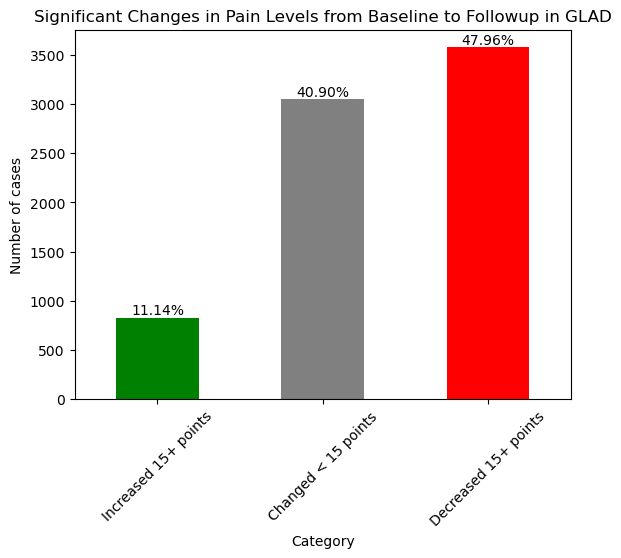

In [33]:
# Calculate the difference
dfg['pain_change'] = dfg['pt12_3764'] - dfg['ptb_3764']

# Define the function to categorize changes of at least 15 points
def pain_categorize_significant_change(pain_change):
    if pain_change <= -15:
        return 'Decreased 15+ points'
    elif pain_change >= 15:
        return 'Increased 15+ points'
    elif pain_change == 0:
        return 'Unchanged'
    else:
        return 'Changed < 15 points'  # This now clearly means the pain changed but less than 15 points either way

# Apply the function to categorize significant pain changes
dfg['pain_significant_change_category'] = dfg['pain_change'].apply(pain_categorize_significant_change)

# Calculate counts for each category of significant pain change
pain_significant_change_counts = dfg['pain_significant_change_category'].value_counts().reindex(['Increased 15+ points', 'Changed < 15 points', 'Decreased 15+ points'])

# Plot
ax = pain_significant_change_counts.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Significant Changes in Pain Levels from Baseline to Followup in GLAD')
plt.xlabel('Category')
plt.ylabel('Number of cases')
plt.xticks(rotation=45)

# Calculate the percentages and annotate the bars
total = pain_significant_change_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


#### Shape

In [34]:
print("Shape of GLAD dataset", dfg.shape)
print("Shape of OAI dataset", df.shape)

Shape of GLAD dataset (7603, 19)
Shape of OAI dataset (4131, 21)
